#Partie I: Object Detection

This section is inspired of the 
https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb

In [1]:
#title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

import os

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

from google.colab import drive
drive.mount('/content/drive')

2.3.0
The following GPU devices are available: /device:GPU:0
Mounted at /content/drive


In [ ]:
!wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
!unzip /content/bird_dataset.zip
!rm /content/bird_dataset.zip

##Object Detection: Faster RCNN
This code has been adapted from https://www.tensorflow.org/hub/tutorials/object_detection

###Loading the model

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

###Useful functions

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  #print("Found %d objects." % len(result["detection_scores"]))
  #print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  #display_image(image_with_boxes)
  
  return result , img

###Extracting the new cropped images

In [ ]:
from tqdm.notebook import tqdm
import os
import shutil



try:
  shutil.rmtree('bird_dataset_crop/')
except: pass

root = 'bird_dataset/'
os.mkdir('bird_dataset_crop/')

for phase in tqdm(os.listdir(root)):
  os.mkdir('bird_dataset_crop/'+phase)
  for label in tqdm(os.listdir(root+phase)):
    path_images = os.path.join(root,phase,label)
    path_crop = os.path.join('bird_dataset_crop',phase,label)
    os.mkdir(path_crop+'/')
    for img in tqdm(os.listdir(path_images)):
      d , full_image  = run_detector(detector,os.path.join(path_images,img))

      highest_score = 0 
      highest_index = -1
      for i,box in enumerate(d['detection_boxes']):
        if 'Bird' in d['detection_class_entities'][i].decode("utf-8"): 
          if d['detection_scores'][i] > highest_score:
            highest_score = d['detection_scores'][i]
            highest_index = i
      box = d['detection_boxes'][highest_index]
      #print(d['detection_class_entities'][highest_index].decode("utf-8"))
      ymin, xmin, ymax, xmax = box

      x1 = int(xmin*full_image.shape[1]) 
      x2 = int(xmax*full_image.shape[1])
      y1 = int(ymin*full_image.shape[0])
      y2 = int(ymax*full_image.shape[0])

      try:
        crop_img = tf.keras.preprocessing.image.array_to_img(full_image[y1:y2,x1:x2])
        #crop_img = crop_img.resize(size=(400,400))
        img_crop_path = os.path.join(path_crop,img)
        #plt.imshow(crop_img)
        #plt.show()
        crop_img.save(img_crop_path)

      except:
        pass

In [13]:
!zip bird_dataset_crop.zip bird_dataset_crop

source = 'bird_dataset_crop.zip'
destination = "drive/MyDrive/recviz/bird_dataset/bird_dataset_crop.zip"

shutil.copy(source, destination)

  adding: bird_dataset_crop/ (stored 0%)


'drive/MyDrive/recviz/bird_dataset/bird_dataset_crop.zip'

Hence, we have created a dataset that is only restricted to the crop of the birds.

#Partie II: Model training

##Loading cropped dataset

In [ ]:
import shutil 
import os
source = 'drive/MyDrive/recviz/bird_dataset_crop.zip'
destination = '/content/bird_dataset_crop.zip'
shutil.copy(source, destination)

!unzip /content/bird_dataset_crop.zip 
!rm /content/bird_dataset_crop.zip

source = 'bird_dataset'
destination = 'both'
shutil.copytree(source,destination)

We copy both the original dataset and the cropped dataset in a folder that we call `both`

In [53]:
for s in os.listdir("bird_dataset_crop/"+phase):
    for image in os.listdir("bird_dataset_crop/"+phase+'/'+s):
      img_name = image.split('.')[0]
      format = image.split('.')[1]
      img_crop = image.split('.')[0]+'crop.'+format
      source = os.path.join("bird_dataset_crop",phase,s,image)
      destination = os.path.join('both',phase,s,img_crop)
      shutil.copy(source,destination)


##Vizualisation 
Here we plot the same image from the original dataset and from the cropped dataset

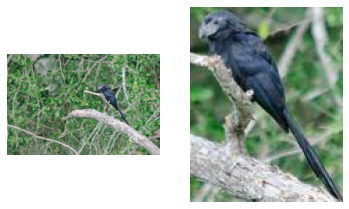

In [111]:
original = Image.open('bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0004_1528.jpg')
crop = Image.open('bird_dataset_crop/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0004_1528.jpg')
plt.subplot(1,2,1)
plt.imshow(original)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(crop)
plt.axis('off')
plt.show()


##CNN architecture

In [64]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train_images', 'val_images']:
            if phase == 'train_images':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_images'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train_images':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train_images':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val_images' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

###Data Loader + ImgAug extension

In [59]:
import imgaug as ia

from imgaug import augmenters as iaa

# wrapper around imgaug compatible with pytorch transforms
class ImgAugTransform:
  def __init__(self, aug):
    self.aug = aug
      
  def __call__(self, img):
    img = np.array(img)
    return Image.fromarray(np.uint8(self.aug.augment_image(img)))
  
  def __repr__(self):
    return self.__class__.__name__ + ' ' + str(self.aug)

In [66]:
from __future__ import print_function, division

import PIL.Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

batch_size = 32

shape = 224

data_transforms = {
    'train_images': transforms.Compose([
                                #NewPad(),
                                transforms.Resize(shape),
                                #transforms.TenCrop(224),
                                transforms.RandomResizedCrop(224),
                                #transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.05, hue=0),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.15*255), per_channel=0.5, name='GaussianNoise'))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 1.0), name='GaussianBlur'))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.CoarseDropout((0.03, 0.15), size_percent=(0.05, 0.2), per_channel=0.2))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.JpegCompression(0.87))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), name='Sharpen'))),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
                                #transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                ])
    ,
    'val_images': transforms.Compose([
        #NewPad(),
        transforms.Resize(shape),
        #transforms.TenCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
"""
data_transforms = {
    'train_images': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.05, hue=0),transforms.RandomAffine(degrees=(-45,45), shear=(20,20), resample=False),transforms.RandomHorizontalFlip()], p=0.75),
        torchvision.transforms.RandomResizedCrop((224,224)),
        torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_images': transforms.Compose([
        transforms.Resize((224,224)),
        torchvision.transforms.RandomResizedCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
} 
"""

data_dir = "both"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train_images','val_images']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train_images','val_images']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train_images','val_images']}
class_names = image_datasets['train_images'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Visualizing a batch of augmented images

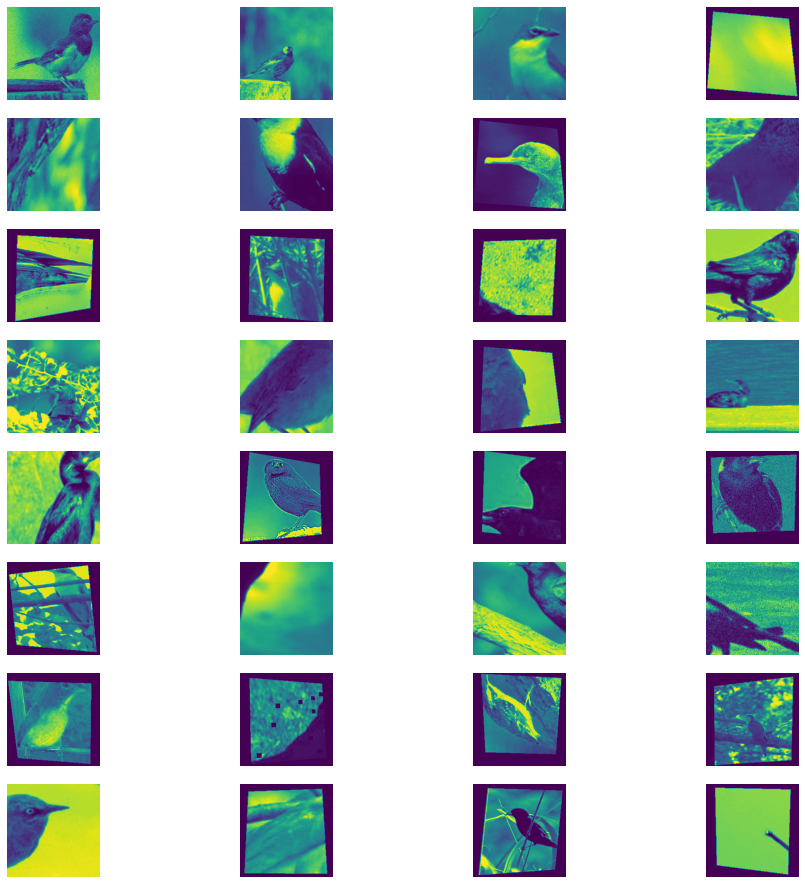

In [72]:
plt.figure(figsize=(16,16))
for i,j in enumerate(next(iter(dataloaders['train_images']))[0]):
  plt.subplot(8,4,i+1)
  plt.imshow(j[0])
  plt.axis("off")
plt.show()

###Training of Resnext101_32x8d

In [77]:
import torch.nn.functional as F

model_resnext_both = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_resnext_both.fc.in_features
model_resnext_both.fc = nn.Linear(num_ftrs,20)
"""
model_ft.fc = nn.Sequential(
                      nn.Flatten(),
                      nn.Linear(num_ftrs, 512),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(num_ftrs, len(train_loader.dataset.classes)),                   
                      nn.LogSoftmax(dim=1))
"""

for child in model_resnext_both.children():
  for param in child.parameters():
    param.requires_grad = False

for param in model_resnext_both.layer4.parameters():
  param.requires_grad = True

for param in model_resnext_both.fc.parameters():
  param.requires_grad = True


model_resnext_both = model_resnext_both.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_resnext_both.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [112]:
from torchsummary import summary

summary(model_resnext_both, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [80]:
model_resnext_both = train_model(model_resnext_both, criterion, optimizer, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
train_images Loss: 2.4864 Acc: 0.3323
val_images Loss: 1.4276 Acc: 0.7184

Epoch 1/39
----------
train_images Loss: 1.4271 Acc: 0.6165
val_images Loss: 0.8467 Acc: 0.7573

Epoch 2/39
----------
train_images Loss: 1.0851 Acc: 0.6895
val_images Loss: 0.6641 Acc: 0.7670

Epoch 3/39
----------
train_images Loss: 0.9294 Acc: 0.7232
val_images Loss: 0.7880 Acc: 0.7767

Epoch 4/39
----------
train_images Loss: 0.8253 Acc: 0.7523
val_images Loss: 0.6815 Acc: 0.7573

Epoch 5/39
----------
train_images Loss: 0.7164 Acc: 0.7823
val_images Loss: 0.5508 Acc: 0.8252

Epoch 6/39
----------
train_images Loss: 0.6964 Acc: 0.7925
val_images Loss: 0.6231 Acc: 0.8252

Epoch 7/39
----------
train_images Loss: 0.6307 Acc: 0.8050
val_images Loss: 0.5353 Acc: 0.8447

Epoch 8/39
----------
train_images Loss: 0.6733 Acc: 0.7957
val_images Loss: 0.7055 Acc: 0.7864

Epoch 9/39
----------
train_images Loss: 0.5882 Acc: 0.8184
val_images Loss: 0.5577 Acc: 0.8058

Epoch 10/39
----------
train_i

####Evaluation on cropped images

In [81]:
import PIL.Image as Image
from tqdm.notebook import tqdm

root= 'bird_dataset_crop/'
test_dir = root + 'test_images/mistery_category'
use_cuda = True

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'drive/MyDrive/recviz/bird_dataset/results3/kaggle_resnext.csv'

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms['val_images'](pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_resnext_both(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')



Succesfully wrote drive/MyDrive/recviz/bird_dataset/results3/kaggle_resnext.csv, you can upload this file to the kaggle competition website


####Evaluation on original images

In [91]:
import PIL.Image as Image
from tqdm.notebook import tqdm

root= 'bird_dataset/'
test_dir = root + 'test_images/mistery_category'
use_cuda = True

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'drive/MyDrive/recviz/bird_dataset/results3/kaggle_resnext_initial.csv'

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms['val_images'](pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_resnext_both(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')



Succesfully wrote drive/MyDrive/recviz/bird_dataset/results3/kaggle_resnext_initial.csv, you can upload this file to the kaggle competition website


###Training a Resnet152_crop

In [83]:
model_resnet152 = models.resnet152(pretrained=True)
num_ftrs = model_resnet152.fc.in_features
lay_unfreeze = ['layer4','layer3']
for name, child in model_resnet152.named_children():
        if name in lay_unfreeze:
          if(name =='layer3'):
            list_bottleneck =[i for i in range(17,36)]
            for n in range(0,36):
              if(n>21):
                for param in child[n].parameters():
                  param.requires_grad=True
              else :
                for param in child[n].parameters():
                  param.requires_grad=False
              
            
          elif(name =='layer4') :
              print(name + 'layer4 has been unfrozen.')
              for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet152.fc = nn.Linear(num_ftrs, 20)

model_resnet152 = model_resnet152.to(device)

criterion = nn.CrossEntropyLoss(reduction= 'mean')

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet152.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_resnet152 = train_model(model_resnet152, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

layer4layer4 has been unfrozen.
Epoch 0/19
----------
train_images Loss: 1.7797 Acc: 0.4556
val_images Loss: 1.1492 Acc: 0.6408

Epoch 1/19
----------
train_images Loss: 1.1263 Acc: 0.6502
val_images Loss: 1.0891 Acc: 0.7087

Epoch 2/19
----------
train_images Loss: 0.9142 Acc: 0.7089
val_images Loss: 1.0716 Acc: 0.6602

Epoch 3/19
----------
train_images Loss: 0.8316 Acc: 0.7403
val_images Loss: 0.8979 Acc: 0.7184

Epoch 4/19
----------
train_images Loss: 0.7788 Acc: 0.7486
val_images Loss: 0.9245 Acc: 0.7670

Epoch 5/19
----------
train_images Loss: 0.7029 Acc: 0.7759
val_images Loss: 0.7955 Acc: 0.7767

Epoch 6/19
----------
train_images Loss: 0.6974 Acc: 0.7754
val_images Loss: 0.8082 Acc: 0.7767

Epoch 7/19
----------
train_images Loss: 0.5512 Acc: 0.8341
val_images Loss: 0.5362 Acc: 0.8155

Epoch 8/19
----------
train_images Loss: 0.4977 Acc: 0.8410
val_images Loss: 0.5810 Acc: 0.8252

Epoch 9/19
----------
train_images Loss: 0.4759 Acc: 0.8563
val_images Loss: 0.7259 Acc: 0.7961

###Training inceptionresnetv2

In [84]:
from __future__ import print_function, division

import PIL.Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

batch_size = 32

shape = 299

data_transforms = {
    'train_images': transforms.Compose([
                                #NewPad(),
                                transforms.Resize(400),
                                #transforms.TenCrop(224),
                                transforms.RandomResizedCrop(shape),
                                #transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.05, hue=0),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.15*255), per_channel=0.5, name='GaussianNoise'))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 1.0), name='GaussianBlur'))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.CoarseDropout((0.03, 0.15), size_percent=(0.05, 0.2), per_channel=0.2))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.JpegCompression(0.87))),
                                ImgAugTransform(iaa.Sometimes(0.1, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), name='Sharpen'))),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
                                #transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                ])
    ,
    'val_images': transforms.Compose([
        #NewPad(),
        transforms.Resize(400),
        #transforms.TenCrop(224),
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = "both"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train_images','val_images']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train_images','val_images']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train_images','val_images']}
class_names = image_datasets['train_images'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [87]:
!pip install cnn_finetune

from cnn_finetune import make_model

     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for cnn-finetune: filename=cnn_finetune-0.6.0-cp36-none-any.whl size=11430 sha256=94c7b3e0dd7fec385ef6f7f6752d433c9ac6552ec68eb0c134ccfb97f63d231d
  Stored in directory: /root/.cache/pip/wheels/12/4f/29/32978e72b606c5f51b6bd10117814deb46c6b63230eef49381
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=9c4da3fb91ddb5dfcdc8f57fadef516f821c9e3e09797e880528aaa565427a51
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built cnn-finetune pretrainedmodels


In [88]:
# Custom classifier to add at the end of a pre-trained architecture
def make_classifier(in_features, num_classes):
    return nn.Sequential(
        nn.Linear(in_features, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )

model_inceptionresnet_fi = make_model('inceptionresnetv2', num_classes=20, pretrained=True, input_size=(400, 400), classifier_factory=make_classifier)

## Then we need to freeze layers at the beginning (the first ones as they play the role of feature extractors)
for name, child in model_inceptionresnet_fi.named_children():
        if name == '_features':
            for param in child.parameters():
                param.requires_grad = False

for name, child in model_inceptionresnet_fi.named_children():
        if name == '_features':
          for n in [9,10,11,12,13,14]:
            for param in child[n].parameters() :
                param.requires_grad =True

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth


In [90]:
model_inceptionresnet_fi = model_inceptionresnet_fi.to(device)

criterion = nn.CrossEntropyLoss(reduction= 'mean')
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_inceptionresnet_fi.parameters(), lr=0.01, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_inceptionresnet_fi = train_model(model_inceptionresnet_fi, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50)

Epoch 0/49
----------
train_images Loss: 2.9079 Acc: 0.1331
val_images Loss: 2.5918 Acc: 0.2913

Epoch 1/49
----------
train_images Loss: 2.0079 Acc: 0.4677
val_images Loss: 1.0243 Acc: 0.6699

Epoch 2/49
----------
train_images Loss: 1.0779 Acc: 0.6400
val_images Loss: 0.7285 Acc: 0.7282

Epoch 3/49
----------
train_images Loss: 0.8533 Acc: 0.7130
val_images Loss: 0.6763 Acc: 0.8058

Epoch 4/49
----------
train_images Loss: 0.6566 Acc: 0.7722
val_images Loss: 0.5354 Acc: 0.8447

Epoch 5/49
----------
train_images Loss: 0.5867 Acc: 0.7985
val_images Loss: 0.5536 Acc: 0.8058

Epoch 6/49
----------
train_images Loss: 0.5201 Acc: 0.8239
val_images Loss: 0.4384 Acc: 0.8641

Epoch 7/49
----------
train_images Loss: 0.4092 Acc: 0.8572
val_images Loss: 0.3940 Acc: 0.8932

Epoch 8/49
----------
train_images Loss: 0.3905 Acc: 0.8692
val_images Loss: 0.4130 Acc: 0.8835

Epoch 9/49
----------
train_images Loss: 0.3572 Acc: 0.8835
val_images Loss: 0.3627 Acc: 0.8835

Epoch 10/49
----------
train_i

####Ealuation on cropped images

In [93]:
import PIL.Image as Image
from tqdm.notebook import tqdm

root= 'bird_dataset_crop/'
test_dir = root + 'test_images/mistery_category'
use_cuda = True

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'drive/MyDrive/recviz/bird_dataset/results3/kaggle_inceptionresnet.csv'

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms['val_images'](pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_inceptionresnet_fi(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')



Succesfully wrote drive/MyDrive/recviz/bird_dataset/results3/kaggle_inceptionresnet.csv, you can upload this file to the kaggle competition website


####Evaluation on original images

In [92]:
import PIL.Image as Image
from tqdm.notebook import tqdm

root= 'bird_dataset/'
test_dir = root + 'test_images/mistery_category'
use_cuda = True

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'drive/MyDrive/recviz/bird_dataset/results3/kaggle_inceptionresnet_initial.csv'

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms['val_images'](pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_inceptionresnet_fi(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')



Succesfully wrote drive/MyDrive/recviz/bird_dataset/results3/kaggle_inceptionresnet_initial.csv, you can upload this file to the kaggle competition website


#Vote

In [94]:
import pandas as pd
l = []
for csv in os.listdir('drive/MyDrive/recviz/bird_dataset/results3/'):
  p = 'drive/MyDrive/recviz/bird_dataset/results3/'+csv
  df = pd.read_csv(p,
                  index_col=[0], parse_dates=[0])
  l.append(df)


finaldf = pd.concat(l, axis=1, join='inner').sort_index()
finaldf

,Category,Category,Category,Category,Category,Category
Id,,,,,,
002f61512a368e4c1434eedacf609957,5,11,5,5,5,5
0247efd7b9d47d036bb4390202a13e69,8,10,18,18,17,10
0267548c2aac82fe3d7e37ae98b00bd7,18,18,18,18,18,18
030c7d18b20ee586db3b74d9966c0348,18,18,18,18,18,17
034abbbb69336b0de7c7c0f2aa1267a6,4,18,18,18,18,18
...,...,...,...,...,...,...
fe95bce0791a7015500d4b9f1d3d32c9,1,1,13,1,1,1
fee2e52c250a812d0e299eb8d0ce558d,15,15,15,15,15,1
fef53a1dada4a77de35c609180d41936,2,2,2,13,2,2


In [96]:
df = pd.DataFrame(finaldf.mode(axis=1)[0],dtype='int')
df.columns = ['Category']
df.to_csv('drive/MyDrive/recviz/bird_dataset/rcnn_vote_final.csv')
